# Subframe 1 (300 bits)

![sub](Subframe1.png)

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython


plt.rcParams["figure.figsize"] = (14,4)

## Parity 

![](Parity.png)

In [85]:
def parity(D1,D0 = np.zeros(30, dtype = int)): # Initialize D* as zeros, incase of TLM
    t = D1.copy()
    if D0[29] == 1:
        t[0:24] = t[0:24] ^ np.ones(24,dtype = int) # Complementing bits before transmission
    
    t[24] = D0[28] ^ D1[0] ^ D1[1] ^ D1[2] ^ D1[4] ^ D1[5] ^ D1[9] ^ D1[10] ^ D1[11] ^ D1[12] ^ D1[13] ^ D1[16] ^ D1[17] ^ D1[19] ^ D1[22]
    t[25] = D0[29] ^ D1[1] ^ D1[2] ^ D1[3] ^ D1[5] ^ D1[6] ^ D1[10] ^ D1[11] ^ D1[12] ^ D1[13] ^ D1[14] ^ D1[17] ^ D1[18] ^ D1[20] ^ D1[23]
    t[26] = D0[28] ^ D1[0] ^ D1[2] ^ D1[3] ^ D1[4] ^ D1[6] ^ D1[7] ^ D1[11] ^ D1[12] ^ D1[13] ^ D1[14] ^ D1[15] ^ D1[18] ^ D1[19] ^ D1[21]
    t[27] = D0[29] ^ D1[1] ^ D1[3] ^ D1[4] ^ D1[6] ^ D1[7] ^ D1[8] ^ D1[12] ^ D1[13] ^ D1[14] ^ D1[15] ^ D1[16] ^ D1[19] ^ D1[20] ^ D1[22]
    t[28] = D0[29] ^ D1[0] ^ D1[2] ^ D1[4] ^ D1[5] ^ D1[6] ^ D1[8] ^ D1[9] ^ D1[13] ^ D1[14] ^ D1[15] ^ D1[16] ^ D1[17] ^ D1[20] ^ D1[21] ^ D1[23]
    t[29] = D0[28] ^ D1[2] ^ D1[4] ^ D1[5] ^ D1[7] ^ D1[8] ^ D1[9] ^ D1[10] ^ D1[12] ^ D1[14] ^ D1[19] ^ D1[21] ^ D1[22] ^ D1[23]
    
    return(t)
    
    
    

## Telemetry
### First word in every subframe (30 bits)
        
![](GPS_Data.png)
![](TLM.png)     

In [86]:
def TLM_F():
    TLM = np.zeros(30, dtype = int)
    TLM[0:8] = [1,0,0,0,1,0,1,1] #Preamble
    TLM[22] = 0 #Integrity status flag, read document
    TLM[23] = 0 # Reserved bit
    # TLM bits 9 to 22 are reserved have to find more data on it
    TLM = parity(TLM)
    
    return(TLM)

<StemContainer object of 3 artists>

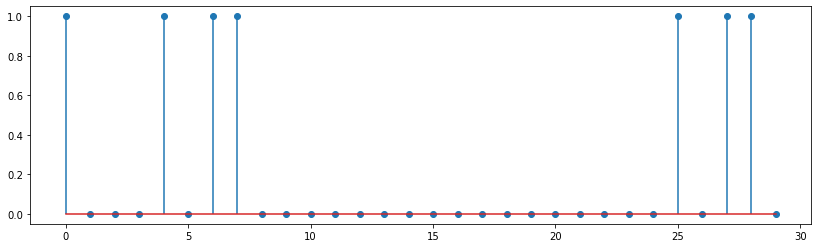

In [87]:
TLM = TLM_F()
plt.stem(TLM)

## GPS Time 
### Using an open source package to obtain gps time and Time of Week 
### Use pip install gps-time 

### refer to IS-GPS-200L.pdf pages 36-37 

![](GPS_time.png)

In [17]:
import datetime
from gps_time.core import GPSTime

In [78]:
def GPS_time(): # Returns week number and TOW based on gps time
    gps_time = GPSTime.from_datetime(datetime.datetime.now())
    TOW = gps_time.time_of_week
    week = gps_time.week_number
    return(week,TOW)

In [79]:
def X1_epochs(Time_of_week): # X1 epochs
    X1 = Time_of_week/1.5
    X1 = int(X1)
    return X1

In [80]:
def Convert(string): # String to list
    list1=[]
    list1[:0]=string
    return list1

In [81]:
def int_to_bin(old_int, n):   # n is length of binary sequence, for TOW count its 19, for week no. it's 10 (12)
    TimeBin = bin(old_int).replace("0b", "")

    
    Tlist = Convert(TimeBin)
    Tlist = list(map(int, Tlist))

    for i in range (n - len(Tlist)): #Padding zeroes
        Tlist.insert(0,0)
    #plt.stem(Tlist)
    return(Tlist) #Time stamp generated

In [88]:
def Z_count_F():
    Z_count = np.zeros(31, dtype = int) #length is 31
    week,TOW = GPS_time()
    X1 = X1_epochs(TOW) # Converting TOW to X1 epochs
    week_bin = int_to_bin(week,12)
    X1_bin = int_to_bin(X1,19)
    Z_count = week_bin + X1_bin
    return(Z_count)

<StemContainer object of 3 artists>

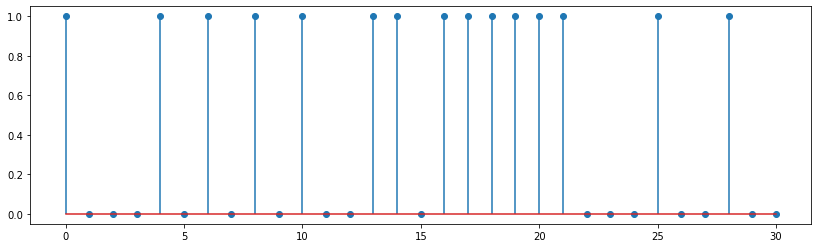

In [89]:
plt.stem(Z_count_F())

## Handover Words

![](HOW.png)


<StemContainer object of 3 artists>

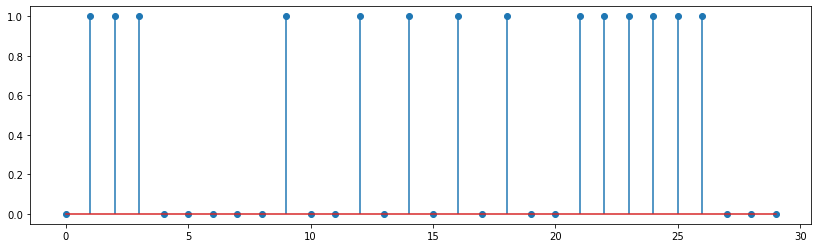

In [96]:
def HOW_F():
    HOW = np.zeros(30, dtype = int)
    HOW[0:17] = Z_count_F()[12:29] # TOW is 17 MSBs of 19LSBs of Z_count
    HOW[17] = 0 # Alert flag, read pg 88 in IS-GPS-200L.pdf
    HOW[18] = 1 # Anti-Spoofing Flag
    Sub_frame_ID = int_to_bin(1, 3)
    HOW[19:22] = Sub_frame_ID # Sub-frame ID, function needed
    
    # Solving for bits 23 and 24
    #HOW[22] = 0
    
    if(parity(HOW,TLM)[28] != 0):
        HOW[22] = 1
        
    #HOW[23] = 0
    
    if(parity(HOW,TLM)[29] != 0):
        HOW[23] = 1
    
    HOW = parity(HOW,TLM)
    return(HOW)


HOW = HOW_F()
plt.stem(HOW)